**Postgrado en Ciencias de la Computación**  
**Inteligencia Artificial (CC6021236)**  
**Semestre 2019-1**  
**Prof. Eugenio Scalise**  

## Tarea 2 (Algoritmos Evolutivos)



***Alumno: Johan Quintero***

***C.I.: 22.668.628***

***Correo: johandym50@gmail.com***

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Sudoku-by-L2G-20050714.svg/240px-Sudoku-by-L2G-20050714.svg.png"
     alt="Ejemplo de Sudoku sin resolver"
     style="float: right; margin-right: 10px;" />El Sudoku es un conocido juego matemático cuyo objetivo es rellenar una cuadrícula de 9 × 9 celdas (81 casillas), dividida en subcuadrículas de 3 × 3 (también llamadas "cajas" o "regiones") con las cifras del 1 al 9 partiendo de algunos números ya dispuestos en algunas de las celdas. Aunque se podrían usar colores, letras, figuras, se conviene en usar números para mayor claridad, lo que importa, es que sean nueve elementos diferenciados, que no se deben repetir en una misma fila, columna o subcuadrícula. \[1\]

El propósito de esta tarea cosniste en utilizar Algoritmos Evolutivos para que mediante una dinámica evolutiva se obtengan Sudokus válidos. En particular, utilizando un algoritmo genético con representación de los estados de los sudokus mediante secuecias o permutaciones.

Para facilitar este trabajo, debe utilizar el framework DEAP \[2\].

Se desea que realice las siguientes actividades:

**UNO.** Implemente una dinámica evolutiva con DEAP que a partir de una población aleatoria (permutaciones aleatorias) la dinámica evolutiva permita obtener al menos un individuo (el mejor) que corresponda a un Sudoku válido.

Para esto, antes de implementar su solución deje claro lo siguiente:

    a. Representación de individuos y poblaciones
    
    b. Función de adaptación/fitness
    
    c. Operadores evolutivos a utilizar

Para esto, se recomienda revisar las propuestas presentadas en el capítulo 11 del libro _Genetics Algoritms with Python_ \[3\] que está disponible en los recursos de la materia.

# Instalar paquete deap

In [2]:
pip install deap

     |████████████████████████████████| 153kB 4.7MB/s 


# Imports, Class y funciones requeridas

In [0]:
import array
import random
import json
import datetime

import numpy

import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools

class Rule:
    Index = None
    OtherIndex = None

    def __init__(self, it, other):
        self.Index = it
        self.OtherIndex = other

def build_validation_rules():
    rules = []
    for index in range(80):
        itsRow = index_row(index)
        itsColumn = index_column(index)
        itsSection = row_column_section(itsRow, itsColumn)

        for index2 in range(index + 1, 81):
            otherRow = index_row(index2)
            otherColumn = index_column(index2)
            otherSection = row_column_section(otherRow, otherColumn)

            if itsRow == otherRow or itsColumn == otherColumn or itsSection == otherSection:
                rules.append(Rule(index, index2))
                
    rules.sort(key=lambda x: x.OtherIndex * 100 + x.Index)
    return rules

def index_row(index):
    return int(index / 9)

def index_column(index):
    return int(index % 9)

def row_column_section(row, column):
    return int(row / 3) * 3 + int(column / 3)

def index_section(index):
    return row_column_section(index_row(index), index_column(index))

def section_start(index):
    return int((index_row(index) % 9) / 3) * 27 + int(index_column(index) / 3) * 3
  
def display(candidate):
  print(" - = -   - = -   - = -")
  file = []
  
  for i in range(81):
    file.append(candidate[i])
    
  for row in range(9):
      line = ' | '.join(
          ' '.join(str(i)
              for i in file[row * 9 + i:row * 9 + i + 3])
          for i in [0, 3, 6])
      print("", line)
      if row < 8 and row % 3 == 2:
        print(" ----- + ----- + -----")
  print(" - = -   - = -   - = - \n")

validationRules = build_validation_rules()

# Inicialización de DEAP

In [0]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Preguntas UNO
### Respuesta A
Los inidividuos serán representados como un array de enteros de tamaño 81, en donde, cada subconjuto de tamaño 9 (es decir, cada fila del sudoku) tendrá al menos 1 aparición de cada número del sudoku (números del 1 al 9), de esa manera se procura que en el array de 81 números enteros se tenga la misma cantidad de cada número, es decir, 9 veces de cada número del 1 al 9.



In [0]:
def initGenerate():
  board = []
  
  for i in range(9):
    geneset = [1,2,3,4,5,6,7,8,9]
    rand = 8
  
    while rand >= 0:
    
      val = random.randint(0,rand)
    
      board.append(geneset[val])
      geneset.pop(val)
    
      rand -= 1
      
  return board

Las poblaciones serán una cantidad repetida de manera aleatoria de los individuos.

In [0]:
toolbox.register("individual", tools.initIterate, creator.Individual, initGenerate)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Respuesta B
Basándonoes en la propuesta presentada en el capítulo 11 del libro *Genetics Algoritms with Python* [3], definimos la función fitness:

In [0]:
def getFitness(individual):
  genes = []
  
  for i in range(81):
    genes.append(individual[i])
    
  try:
    firstFailingRule = next(rule for rule in validationRules if genes[rule.Index] == genes[rule.OtherIndex])      
  except StopIteration:
    fitness = 100
  else:
    fitness = (1 + index_row(firstFailingRule.OtherIndex)) * 10 + (1 + index_column(firstFailingRule.OtherIndex))
    
  return fitness,

En donde, se recibe como parametro el individuo a evaluar y se retorna el valor fitness de dicho individuo. En la función fitness haremos uso reglas de referencia para mantener la unicidad de filas, columnas y secciones, tomando en cuenta el índice del punto de inconsistencia y comparándolo con los elementos asociados con índices más bajo. Este proceso se realiza de izquierda a derecha en cada índice, una vez que se resuelve el conflicto en un índice con un elemento inconsistente (entiéndase por elemento inconsistente, como aquel número que provoca un sudoku inválido o que incumple con alguna regla del sudoku), se procede a evaluar el siguiente índice y asi sucesivamente. De esa manera se garantiza que se construirá el sudoku ordenadamente de izquierda a derecha y de abajo hacia arriba, es decir, de manera ascendente.

### Respuesta C

En su mayoría se usaron operadores proporcionados por la librería DEAP [2]:

**- Mate:** como operador de cruce se usó el proporcionado por la librería DEAP: *cxUnitFormPartialyMatched*, con una probabilidad de *indpb=0.3*

**- Mutate:** como operador de mutación se usó una función personalizada basándose en [3], en donde, se toman en cuenta las reglas de referencia para realizar la mutación de un individuo usando el índice del elemento inconsistente como punto de partida para realizar la mutación.


In [0]:
def mutate(genes):
  try:
    selectedRule = next(rule for rule in validationRules if genes[rule.Index] == genes[rule.OtherIndex])
  except StopIteration:
    return genes,
  
  if selectedRule is None:
    return genes,

  if index_row(selectedRule.OtherIndex) % 3 == 2 and random.randint(0, 10) == 0:
    sectionStart = section_start(selectedRule.Index)
    current = selectedRule.OtherIndex

    while selectedRule.OtherIndex == current:
      shuffle_in_place(genes, sectionStart, 80)
      selectedRule = next(rule for rule in validationRules if genes[rule.Index] == genes[rule.OtherIndex])
      
    return genes,
  
  row = index_row(selectedRule.OtherIndex)
  start = row * 9
  indexA = selectedRule.OtherIndex
  indexB = random.randrange(start, len(genes))
  genes[indexA], genes[indexB] = genes[indexB], genes[indexA]
  
  return genes,

def shuffle_in_place(genes, first, last):
  while first < last:
    index = random.randint(first, last)
    genes[first], genes[index] = genes[index], genes[first]
    first += 1

**- Select:** como operador de selección se usó el proporcionado por la librería DEAP: *selTournament*, con un valor de 10 participantes en el torneo (*tournsize=10*)

**- Evaluate:** como función fitness se usó la comentada anteriormente en la respuesta **b**. Adicionalmente, se usó la función *DeltaPenalty* de la librería DEAP para penalizar a los individuos inválidos que se generen en alguna iteración del algoritmo, a esta función se le pasan como parámetros: una función *feasible* que determinará si el individuo actual es válido o no, el valor que se le asignará como valor fitness en caso de que el individuo sea inválido (para este caso el valor es 20) y la función *distance* que determinará la "distancia" que posee el individuo inválido para poder ser un individuo válido. 
Se considera como individuo inválido, aquellos individuos que no tienen la misma cantidad de cada uno de los números, es decir, aquellos que no tienen 9 veces los números del 1 al 9.

In [0]:
def feasible(individual):
  count = [0,0,0,0,0,0,0,0,0]
  invalid = 0
  
  for i in range(81):
    count[individual[i] - 1] += 1
    
  for i in range(9):
    if count[i] != 9:
      return False
    
  return True

def distance(individual):
  count = [0,0,0,0,0,0,0,0,0]
  invalid = 0
  
  for i in range(81):
    count[individual[i] - 1] += 1
    
  for i in range(9):
    if count[i] != 9:
      invalid += 1
      
  return invalid

La representación de los operadores es la siguiente:



In [0]:
def operadores():  
  toolbox.register("mate", tools.cxUniformPartialyMatched, indpb=0.3)
  toolbox.register("mutate", mutate)
  toolbox.register("select", tools.selTournament, tournsize=10)
  toolbox.register("evaluate", getFitness)
  toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, 20, distance))

# Dinámica Evolutiva

In [0]:
def evolve(seed):
  operadores()
  
  random.seed(seed)

  pop = toolbox.population(n=300)
  hof = tools.HallOfFame(1)
  
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", numpy.mean)
  stats.register("std", numpy.std)
  stats.register("min", numpy.min)
  stats.register("max", numpy.max)
    
  pop, logbook = algorithms.eaSimple(pop, toolbox, 0.6, 0.4, 100, stats=stats, halloffame=hof)
    
  return pop, logbook, hof

# Casos de prueba

In [12]:

print("Caso 1:")
pop1, stats1, hof1 = evolve(0)
display(hof1[0])
print("Caso 2:")
pop2, stats2, hof2 = evolve(1)
display(hof2[0])
print("Caso 3:")
pop3, stats3, hof3 = evolve(2)
display(hof3[0])
print("Caso 4:")
pop4, stats4, hof4 = evolve(3)
display(hof4[0])
print("Caso 5:")
pop5, stats5, hof5 = evolve(4)
display(hof5[0])

Caso 1:
gen	nevals	avg  	std    	min	max
0  	300   	23.04	2.53214	21 	34 
1  	232   	18.95	7.23239	11 	34 
2  	237   	21.1133	8.85704	11 	35 
3  	252   	20.6533	9.33201	11 	36 
4  	227   	24.4667	9.99844	11 	37 
5  	237   	25.4833	10.278 	11 	37 
6  	225   	26.6567	10.2208	11 	39 
7  	213   	28.7833	10.2747	11 	39 
8  	238   	30.4333	10.3836	11 	43 
9  	221   	32.8933	10.4618	11 	44 
10 	225   	34.19  	11.9158	12 	46 
11 	235   	32.3467	13.4382	14 	48 
12 	236   	33.24  	14.0692	14 	48 
13 	230   	34.7333	14.6327	14 	49 
14 	224   	36.5333	14.7455	14 	49 
15 	228   	34.8067	15.3389	13 	51 
16 	235   	38     	14.9644	15 	54 
17 	227   	42.63  	13.9659	14 	56 
18 	220   	42.23  	16.7765	15 	56 
19 	217   	40.92  	18.5347	13 	58 
20 	236   	38.8833	19.4495	14 	59 
21 	234   	39.43  	19.9093	13 	59 
22 	223   	41.7967	19.9398	13 	59 
23 	244   	41.8967	20.0984	13 	59 
24 	210   	48.2433	18.0105	14 	62 
25 	228   	49.2033	17.4714	16 	62 
26 	222   	44.7167	19.8904	13 	63 
27 	229   	41.6933

**DOS.** Luego de entonar los parámetros del algoritmo y los operadores genéticos, muestre (preferiblemente usando gráficos) información relevante con respecto a la dinámica evolutiva. Adicionalmente, analice sus resultados.

# Pregunta DOS

Para escoger los parámetros a usar, se realizaron muchas pruebas con diferentes permutaciones de parámetros para analizar los resultados y de esa manera poder tomar una decisión a la hora de elegir los parámetros definitivos. 

Para el algoritmo implementado se usó una probablidad de cruce de 0.6 y una probabilidad de mutación de 0.4. En base a los resultados realizados con diferentes combinaciones, al observar los resultados obtenidos en cada una, se observó que ésta combinación es la que arrojó mejores resultados, por lo que se tomó la decisión de usar estos parámetros como definitivos para el algoritmo evolutivo. 

Cabe destacar que para la solución implementada, la función de mutación tiene un papel fundamental para que la ejecución no se quede "estancada" en un mismo valor fitness y avance. Este problema se observó al probar todos y cada uno de los operadores de mutación que proporciona la librería DEAP, es por eso que se tomó la decisión de implementar una función personalizada para la mutación, basándose en [3].

A continuación, se muestran los gráficos que reflejan los resultados obtenidos y el comportamiento de la solución implementada en los 5 casos de prueba ejecutados:

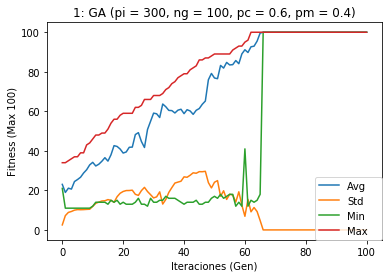

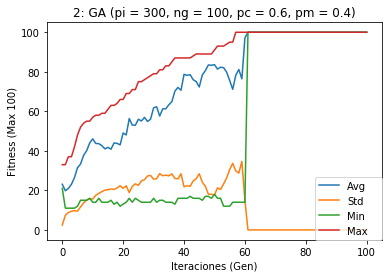

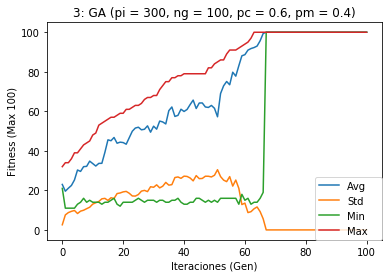

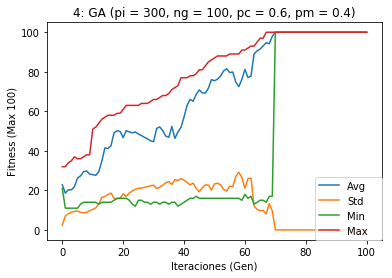

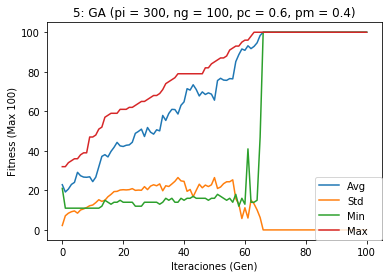

In [13]:
plt.subplot(111)
plt.plot(stats1.select("avg"), label="Avg")
plt.plot(stats1.select("std"), label="Std")
plt.plot(stats1.select("min"), label="Min")
plt.plot(stats1.select("max"), label="Max")
plt.legend(bbox_to_anchor=(0.8, 0.0, 0.2, .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.title('1: GA (pi = 300, ng = 100, pc = 0.6, pm = 0.4)')
plt.ylabel('Fitness (Max 100)')
plt.xlabel('Iteraciones (Gen)')
plt.show()

plt.subplot(111)
plt.plot(stats2.select("avg"), label="Avg")
plt.plot(stats2.select("std"), label="Std")
plt.plot(stats2.select("min"), label="Min")
plt.plot(stats2.select("max"), label="Max")
plt.legend(bbox_to_anchor=(0.8, 0.0, 0.2, .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.title('2: GA (pi = 300, ng = 100, pc = 0.6, pm = 0.4)')
plt.ylabel('Fitness (Max 100)')
plt.xlabel('Iteraciones (Gen)')
plt.show()

plt.subplot(111)
plt.plot(stats3.select("avg"), label="Avg")
plt.plot(stats3.select("std"), label="Std")
plt.plot(stats3.select("min"), label="Min")
plt.plot(stats3.select("max"), label="Max")
plt.legend(bbox_to_anchor=(0.8, 0.0, 0.2, .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.title('3: GA (pi = 300, ng = 100, pc = 0.6, pm = 0.4)')
plt.ylabel('Fitness (Max 100)')
plt.xlabel('Iteraciones (Gen)')
plt.show()

plt.subplot(111)
plt.plot(stats4.select("avg"), label="Avg")
plt.plot(stats4.select("std"), label="Std")
plt.plot(stats4.select("min"), label="Min")
plt.plot(stats4.select("max"), label="Max")
plt.legend(bbox_to_anchor=(0.8, 0.0, 0.2, .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.title('4: GA (pi = 300, ng = 100, pc = 0.6, pm = 0.4)')
plt.ylabel('Fitness (Max 100)')
plt.xlabel('Iteraciones (Gen)')
plt.show()

plt.subplot(111)
plt.plot(stats5.select("avg"), label="Avg")
plt.plot(stats5.select("std"), label="Std")
plt.plot(stats5.select("min"), label="Min")
plt.plot(stats5.select("max"), label="Max")
plt.legend(bbox_to_anchor=(0.8, 0.0, 0.2, .102), loc=3, ncol=1, mode="expand", borderaxespad=0.)
plt.title('5: GA (pi = 300, ng = 100, pc = 0.6, pm = 0.4)')
plt.ylabel('Fitness (Max 100)')
plt.xlabel('Iteraciones (Gen)')
plt.show()


Observando los gráficos resultantes, se puede notar fácilmente que las ejecuciones realizadas con los diferentes casos de pruebas, llegan al resultado esperado (valor fitness 100) aproximadamente entre el Gen 50 y el Gen 70, es por eso que se decidió usar como parámetro del número de genes en el algoritmo evolutivo el valor de 100 para que de esta manera logre mostrar el valor objetivo.

También, se puede observar que en cada Gen el valor del fitness mínimo es aproximadamente 20. Esto se debe a la penalización que se le realiza al valor fitness de cada individuo cuando éste no es un invidividuo válido.

En cuanto al promedio de los valores fitness por cada gen, se observa que dicho promedio se encuentra siempre cerca del fitness max, lo que significa que la mayoría de lo individuos usados se encuentran cerca del valor esperado, sin embargo, este promedio se ve afectado precisamente por aquellos individuos que son inválidos y por lo tanto, son penalizados.

Por último, se tiene la desviación estándar la cual se mantiene relativamente "baja" a lo largo de todos las iteraciones. Lo cual indica que la mayor parte de los datos de la muestra tienden a estar agrupados cerca de la media aritmética (valor esperado) [4].

**TRES.** Suponga que se modifica el problema para que busque la solución a un Sudoku específico (por ejemplo, el de la imagen mostrada arriba). Indique:

    a. Qué cambios debe realizar para generar la población inicial.
    
    b. Qué cambios debe realizar en los operadores genéticos
    
    c. Implemente la dinámica evolutiva considerando este cambio. (opcional)
    
    d. Muestre y analice los resultados. (opcional)
       
**Nota:** si desarrolla las partes c y d puede obtener hasta 5 puntos adicionales en la tarea.

# Preguntas TRES
### Respuesta A

Para generar la población inicial se usa la misma idea de la pregunta **UNO. a.**, pero tomando en cuenta los valores que posee el sudoku de entrada, los cuales no pueden ser modificados, por lo tanto, por cada fila se generarán números aleatorios que no estén siendo usados en esa fila por el sudoku de entrada y que cumplan con las condiciones mencionadas anteriormente, estos valores se usarán para llenar los espacios que contengan valor 0 en el sudoku de entrada, que significa un espacio vacío.

In [0]:
initSudoku = []

def initGenerateOne():
  board = []
  ind = 0
  
  for i in range(9):
    geneset = [1,2,3,4,5,6,7,8,9]
    rand = 8
    
    for j in range(ind, ind + 9):
        if initSudoku[j] != 0:
          for k in range(9):
            if initSudoku[j] == geneset[k]:
              geneset.pop(k)
              break
    
    while rand >= 0:
      
      if initSudoku[ind] != 0:
        board.append(initSudoku[ind])
      else:
        val = random.randint(0, len(geneset) - 1)
        board.append(geneset[val])
        geneset.pop(val)
    
      rand -= 1
      ind += 1
      
  return board

toolbox = base.Toolbox()

toolbox.register("individual", tools.initIterate, creator.Individual, initGenerateOne)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

### Respuesta B

Básicamente el cambio que se debe realizar en los operadores genéticos es que al ejecutar dichos operadores, se procure que no se modifiquen los valores ingresados en el sudoku inicial, es decir, los valores fijos que no se pueden cambiar. Esta modificación sería aplicada en el operador de cruce y el operador de mutación.

Para el operador de cruce se puede usar el proporcionado por la librería DEAP llamado **cxTwoPoint**, ya que ejecuta dos puntos de cruce para los individuos seleccionados. Debido a esto, en ambos individuos no se modificarán los valores fijos iniciales, ya que al hacer el cruce, de un individuo estaría pasando al otro los valores fijos en su posición correcta y viceversa, por lo tanto ambos quedaría con sus valores fijos en sus posiciones correctas y lo que se cambiaría sería los valores aleatorios agregados en la ejecución del algoritmo.

En cuanto a la función fitness, primero se debe modificar la función **feasible**, la encargada de indicar si un individuo es válido o no, de manera que, si el individuo a evaluar no tiene los valores fijos o iniciales en la posición correcta, lo considere un individuo inválido y lo penalice con la función **DealtaPenalty**.

In [0]:
def feasibleOne(individual):
  count = [0,0,0,0,0,0,0,0,0]
  
  for i in range(81):
    count[individual[i] - 1] += 1
    
  for i in range(9):
    if count[i] != 9:
      return False
    
  for i in range(81):
    if initSudoku[i] != 0 and initSudoku[i] != individual[i]:
      return False
  
  return True

En segundo lugar, se debe cambiar la idea de la función fitness, debido a que la idea usada anteriormente de las reglas de referencia, no nos serviría para este caso, ya que no se puede ir construyendo el sudoku en orden ascendente, debido a que se puede presentar el caso que en un determinado punto del sudoku, uno de los número ya "construidos" y asignado "correctamente" puede ser inconsistente con un valor fijo inicial. Por ejemplo: puede que el sudoku esté siendo construido correctamente en orden ascendente, y que el conflicto los encuentra en la posición 78 y es justamente un valor fijo que no se puede modificar, y éste es inconsistente con un valor agregado en la primera fila, en ese caso tendríamos que reconstruir todo el sudoku desde la primera fila e iniciar todo el proceso nuevamente, y este proceso se podría repetir muchisimas veces, quedándose estancada la ejecución del algoritmo.

Una opción para función fitness, es tomar en cuenta el número de filas, columnas y secciones que tienen sus nueve digitos (del 1 al 9), en donde, el valor fitness óptimo sería 27, ya que si se tienen 9 filas, 9 columnas y 9 secciones que posean sus nueve dígitos, al realizar la suma entre las 3 el valor sería: 9 + 9 + 9 = 27.

In [0]:
def getFitnessOne(individual):
  file = []
  count = 0
  fitness = 0
  
  for i in range(9):
    for j in range(9):
      file.append(individual[i * 9 + j])
      
    file.sort()
    
    for k in range(9):
      if file[k] == k + 1:
        count += 1
        
    if count == 9:
      fitness += 1
      
    file = []
    count = 0
  
  for i in range(9):
    for j in range(9):
      file.append(individual[j * 9 + i])
    
    file.sort()
    
    for k in range(9):
      if file[k] == k + 1:
        count += 1
        
    if count == 9:
      fitness += 1
      
    file = []
    count = 0
  
  for i in range(9):
    sector = i * 3
    
    if 2 < i and i < 6:
      sector += 9 * 2
    if 5 < i:
      sector += 9 * 4
    
    for j in range(9):
      
      if j + 1 == individual[sector]:
        count += 1
      elif j + 1 == individual[sector + 1]:
        count += 1
      elif j + 1 == individual[sector + 2]:
        count += 1
      elif j + 1 == individual[sector + 9]:
        count += 1
      elif j + 1 == individual[sector + 10]:
        count += 1
      elif j + 1 == individual[sector + 11]:
        count += 1
      elif j + 1 == individual[sector + 18]:
        count += 1
      elif j + 1 == individual[sector + 19]:
        count += 1
      elif j + 1 == individual[sector + 20]:
        count += 1
    
    if count == 9:
      fitness += 1
      
    count = 0
    
  return fitness,

Para la función de mutación se propone modificar una función proporcionada por la librería DEAP y modificarla de manera que no modifique los valores fijos. En este caso se hace uso de la función **mutShuffleIndexes** y se modifica para que se adapte a las necesidades del problema.

In [0]:
def mutateOne(individual, indpb):
  size = len(individual)
    
  for i in range(size):
    if initSudoku[i] == 0:
      
      if random.random() < indpb:
        
        swap_indx = random.randint(0, size - 2)
        
        if swap_indx >= i:
          swap_indx += 1
        
        if initSudoku[swap_indx] == 0:
          individual[i], individual[swap_indx] = individual[swap_indx], individual[i]
          

  return individual,

Basándonos en lo antes explicado, los operadores quedarían de la siguiente manera:

In [0]:
def operadoresOne():  
  toolbox.register("mate", tools.cxTwoPoint)
  toolbox.register("mutate", mutateOne, indpb=0.05)
  toolbox.register("select", tools.selTournament, tournsize=5)
  toolbox.register("evaluate", getFitnessOne)
  toolbox.decorate("evaluate", tools.DeltaPenalty(feasibleOne, 0))

La función **evolve** quedaría similar a la anterior, con la diferencia que en este caso se la pasa otro parámetro que será el sudoku inicial con los valores fijos que hay que tomar en cuenta en los operadores y que no pueden ser modificados.

In [0]:
def evolveOne(seed, sudoku):
  display(sudoku)
  
  global initSudoku
  
  initSudoku = sudoku
  
  operadoresOne()
  
  random.seed(seed)

  pop = toolbox.population(n=300)
  hof = tools.HallOfFame(1)
  
  stats = tools.Statistics(lambda ind: ind.fitness.values)
  stats.register("avg", numpy.mean)
  stats.register("std", numpy.std)
  stats.register("min", numpy.min)
  stats.register("max", numpy.max)
    
  pop, logbook = algorithms.eaSimple(pop, toolbox, 0.7, 0.3, 100, stats=stats, halloffame=hof)
    
  return pop, stats, hof

Al momento de ejecutar los casos de prueba, se realiza de la misma manera con el cambio anteriormente mencionado, se le pasa como segundo parámetro un array de int que representa el sudoku inicial.

In [77]:
pop, stats, hof = evolveOne(0, [5,3,0,0,7,0,0,0,0,6,0,0,1,9,5,0,0,0,0,9,8,0,0,0,0,6,0,8,0,0,0,6,0,0,0,3,4,0,0,8,0,3,0,0,1,7,0,0,0,2,0,0,0,6,0,6,0,0,0,0,2,8,0,0,0,0,4,1,9,0,0,5,0,0,0,0,8,0,0,7,9])
display(hof[0])

 - = -   - = -   - = -
 5 3 0 | 0 7 0 | 0 0 0
 6 0 0 | 1 9 5 | 0 0 0
 0 9 8 | 0 0 0 | 0 6 0
 ----- + ----- + -----
 8 0 0 | 0 6 0 | 0 0 3
 4 0 0 | 8 0 3 | 0 0 1
 7 0 0 | 0 2 0 | 0 0 6
 ----- + ----- + -----
 0 6 0 | 0 0 0 | 2 8 0
 0 0 0 | 4 1 9 | 0 0 5
 0 0 0 | 0 8 0 | 0 7 9
 - = -   - = -   - = - 

gen	nevals	avg    	std     	min	max
0  	300   	9.08333	0.310466	9  	12 
1  	251   	3.01333	4.22372 	0  	10 
2  	244   	2.67   	4.08833 	0  	10 
3  	220   	2.99   	4.16852 	0  	10 
4  	232   	3.15667	4.2621  	0  	10 
5  	245   	3.52333	4.41015 	0  	11 
6  	251   	3.58333	4.45381 	0  	11 
7  	256   	3.72   	4.51681 	0  	11 
8  	242   	4.53667	4.6399  	0  	11 
9  	242   	6.32667	4.29961 	0  	11 
10 	221   	7.57667	3.85454 	0  	11 
11 	237   	6.90667	4.32488 	0  	11 
12 	239   	6.7    	4.40795 	0  	11 
13 	238   	6.7    	4.43434 	0  	11 
14 	231   	6.39333	4.76081 	0  	11 
15 	232   	6.58   	4.88299 	0  	11 
16 	241   	7.85667	4.40183 	0  	12 
17 	237   	9.31667	3.29085 	0  	12 
18 	225   	9.46

### Consideraciones:  

- Utilice una copia de este Jupyter Notebook usando Python3 para hacer el proyecto.
- Renombre el documento como `Tarea_2_-_Nombre1_Apellido1_-_Nombre2_Apellido2.ipynb`
- Agregue una celda de referencias y cite **todo** recurso que utilice. Utilice formato IEEE para las referencias.
- Esta tarea se puede realizar en grupos de dos personas.
- Para la entrega, hospede su solución en http://colab.research.google.com. La fecha y hora de la última modificación del documento será considerada el *timestamp* de entrega. Para mayor seguridad, envíe también el notebook como una anexo por correo a `escalise at gmail dot com`.
- Todas las celdas de código de la entrega deben estar ejecutadas para facilitar la corrección; sin embargo, se utilizará un set de casos de prueba para la revisión.
- La fecha de entrega de esta tarea es el miércoles 31/07/2019, 11:59:59 PM (VET time).

### Referencias

\[1\] [Sudoku](https://es.wikipedia.org/wiki/Sudoku). Wikipedia, La enciclopedia libre, 2019.

\[2\] DEAP (Distributed Evolutionary Algorithms in Python). Repositorio: https://github.com/DEAP/deap, Documentación: https://deap.readthedocs.io/

\[3\] Clinton Sheppard. *Genetics Algorithms with Python*. 2016. (Disponible en el directorio compartido de Drive de la materia)

\[4\] [Desviación típica](https://es.wikipedia.org/wiki/Desviaci%C3%B3n_t%C3%ADpica). Wikipedia, La enciclopedia libre, 2019.